In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_trader import EMA_trader

In [2]:
history = pd.read_csv('./binance_DOGEBTC_1m.csv') # dogecoin data
history = history.iloc[0:80000]
prices = history['open'].tolist()

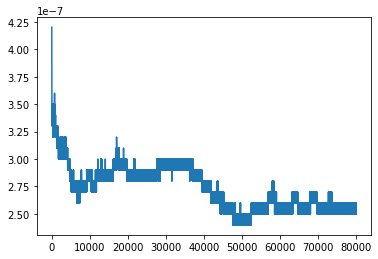

In [3]:
plt.plot(prices)

In [4]:
tr = EMA_trader()

optimization_period = 10000

# quantities of Doge/BTC
parameters = tr.optimize_threaded(prices[:optimization_period])
tr.set_params(*parameters)

doge, BTC = 50, 50
bt = np.zeros_like(prices[optimization_period:])
dg = np.zeros_like(prices[optimization_period:])

prev_price = prices[optimization_period - 1]

num_buys = num_sells = 0

for i, price in enumerate(prices[optimization_period:], optimization_period):
    percent_change = (price - prev_price) / prev_price
    doge *= 1 + percent_change

    action = tr.action(price)
    if action == tr.OrderSide.BUY:  # buy
        if BTC > 0: 
            doge += .999 * BTC
            BTC = 0
            num_buys += 1
    elif action == tr.OrderSide.SELL:  # sell
        if doge > 0:
            BTC += 0.999 * doge
            doge = 0
            num_sells += 1

    if BTC + doge < 1e-9:
        print('Bust')
        break

    bt[i-optimization_period] = BTC
    dg[i-optimization_period] = doge
    prev_price = price

    # why do this in 2 steps? because we could potentially throw the
    # call to `tr.optimize` into its own thread, and update tr once it is done.
    if (i-2) % optimization_period == 0:
        t0 = time.perf_counter()
        parameters = tr.optimize_threaded(prices[i-optimization_period:i])
        tr.set_params(*parameters)
        print(f"{100 * (i - optimization_period) / (len(prices) - optimization_period):.2f}%: Optimized in {time.perf_counter() - t0:.2f} s")
        print(f"BTC: {BTC}\tDOGE: {doge}\tNUM BUYS: {num_buys}\tNUM SELLS: {num_sells}")

103.600 (0.1, 9, 0.0, 0)
103.600 (0.1, 9, 0.0, 0)
0.00%: Optimized in 10.00 s
BTC: 50	DOGE: 50.0	NUM BUYS: 0	NUM SELLS: 0
107.300 (0.6, 8, 0.2, 2)
14.29%: Optimized in 10.57 s
BTC: 125.3029934192036	DOGE: 0.0	NUM BUYS: 3	NUM SELLS: 4
103.468 (0.1, 9, 0.0, 0)
28.57%: Optimized in 13.09 s
BTC: 125.3029934192036	DOGE: 0.0	NUM BUYS: 3	NUM SELLS: 4
100.000 (0.0, 9, 0.0, 0)
42.86%: Optimized in 13.26 s
BTC: 0	DOGE: 152.3594863933636	NUM BUYS: 8	NUM SELLS: 8
104.063 (0.2, 5, 0.0, 0)
57.15%: Optimized in 13.63 s
BTC: 0	DOGE: 141.07359851237365	NUM BUYS: 8	NUM SELLS: 8
103.896 (0.1, 9, 0.0, 0)
71.43%: Optimized in 13.50 s
BTC: 0	DOGE: 141.0735985123736	NUM BUYS: 8	NUM SELLS: 8
103.896 (0.1, 9, 0.0, 0)
85.72%: Optimized in 13.76 s
BTC: 0	DOGE: 146.71654245286854	NUM BUYS: 8	NUM SELLS: 8


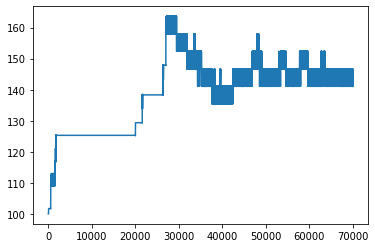

In [6]:
plt.plot(bt + dg)